In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, initializers
import numpy as np

In [2]:
def load_and_preprocess_data():
    # loading the data as train and test
    data = np.load('../../data/electron-photon-pairs.npz', allow_pickle=True)
    pairs_train = data["pairs_train"]
    labels_train = data["labels_train"]
    pairs_test = data["pairs_test"]
    labels_test = data["labels_test"]
    return pairs_train, labels_train, pairs_test, labels_test

# def create_data_augmentation_layer(input_shape):
#     return tf.keras.Sequential([
#         tf.keras.layers.Input(shape=input_shape),
#         tf.keras.layers.RandomFlip("horizontal"),
#         tf.keras.layers.RandomRotation(0.2),
#         tf.keras.layers.RandomZoom(0.2),
#         tf.keras.layers.RandomContrast(0.2),
#     ])

 

# class SiameseModel(tf.keras.Model):
#     def __init__(self, input_shape):
#         super(SiameseModel, self).__init__()
#         self.base_model = create_base_model(input_shape)
#         self.data_augmentation = create_data_augmentation_layer()

#     def call(self, inputs):
#         img1, img2 = inputs
#         img1 = self.data_augmentation(img1)
#         img2 = self.data_augmentation(img2)
#         feat1 = self.base_model(img1)
#         feat2 = self.base_model(img2)
#         distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
#                             )([feat1, feat2])
    
#         model = models.Model([img1, img2], distance)
#         return model

# def info_nce_loss(temperature=0.1):
#     def loss(features1,features2):
#         batch_size = tf.shape(features1)[0]
#         labels = tf.range(batch_size)
            
#         features1_norm = tf.math.l2_normalize(features1, axis=1, epsilon=tf.cast(1e-12, tf.float32))
#         features2_norm = tf.math.l2_normalize(features2, axis=1, epsilon=tf.cast(1e-12, tf.float32))
    
            
#         logits = tf.matmul(features1_norm, features2_norm, transpose_b=True) / temperature
         
#         loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
#         return tf.reduce_mean(loss)
#     return loss

In [3]:
train_images, train_labels, test_images, test_labels = load_and_preprocess_data()

### Defining the Model

In [4]:
def info_nce_loss(temperature=0.1):
    def loss(y_true, embeddings):
        # Unpack the embeddings
        embeddings1, embeddings2 = tf.split(embeddings, 2, axis=1)
        
        # Normalize embeddings
        embeddings1 = tf.math.l2_normalize(embeddings1, axis=1)
        embeddings2 = tf.math.l2_normalize(embeddings2, axis=1)
        
        # Compute similarity matrix
        similarity_matrix = tf.matmul(embeddings1, embeddings2, transpose_b=True) / temperature
        
        # Compute InfoNCE loss
        batch_size = tf.shape(embeddings1)[0]
        labels = tf.range(batch_size)
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            labels, similarity_matrix, from_logits=True
        )
        return tf.reduce_mean(loss)
    return loss

In [5]:
# # Contrastive loss function based on margin
# def contrastive_loss(margin=1.0):
#     def loss(y_true, dist):
#         y_true = tf.cast(y_true, tf.float32)
#         square_dist = tf.square(dist)
#         margin_square = tf.square(tf.maximum(margin - dist, 0))
#         return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
#     return loss

In [6]:
def create_base_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializers.HeNormal())) # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Conv layer 2
    model.add(layers.Dropout((0.5)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    return model

In [7]:
# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    # input_0 = create_data_augmentation_layer(input_shape)
    # input_1 = create_data_augmentation_layer(input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    embeddings = tf.concat([processed_0, processed_1], axis=1)

    # distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
    #                         )([processed_0, processed_1])
    
    model = models.Model([input_0, input_1], embeddings)
    
    return model

In [ ]:
# Define the model
# import os
# checkpoint_path = "../../saved_models/exp1_cnn_base_1_ep/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

input_shape = train_images.shape[2:]
siamese_network = create_siamese_network(input_shape)

siamese_network.compile(loss=info_nce_loss(), optimizer=optimizers.RMSprop(learning_rate=1e-3))

history = siamese_network.fit([train_images[:, 0], train_images[:, 1]], train_labels,
    validation_data=([test_images[:, 0], test_images[:, 1]], test_labels),
    epochs=10,
    batch_size=50000,
    # callbacks=[cp_callback]
)



Epoch 1/10



In [51]:
siamese_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 64)                   22976     ['input_8[0][0]',             
                                                                     'input_9[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None,)                      0         ['sequential_2[0][0]',  

<Axes: title={'center': 'Learning History'}>

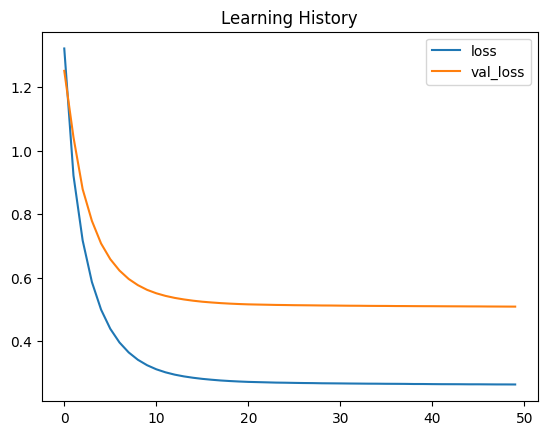

In [52]:
pd.DataFrame(history.history).plot(title="Learning History")

### Evaluation of the model

In [53]:
# Predictions from the model
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

6225/6225 [==============================] - 28s 4ms/step


In [54]:
distance

array([8.8643283e-04, 5.1073229e-04, 3.6187175e-05, ..., 2.3375833e-06,
       8.0455131e-05, 3.9003426e-05], dtype=float32)

In [55]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [56]:
y_pred = distances_to_labels(distance)

In [57]:
def plot_samples_with_predictions(test_pairs, test_labels, predictions, distances, size,num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(test_pairs[i, 0].reshape(size, size), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(test_pairs[i, 1].reshape(size, size), cmap='gray')
        ax.axis('off')

        label = test_labels[i]
        pred = predictions[i]
        dist = distances[i]
        plt.title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    plt.tight_layout()
    plt.show()

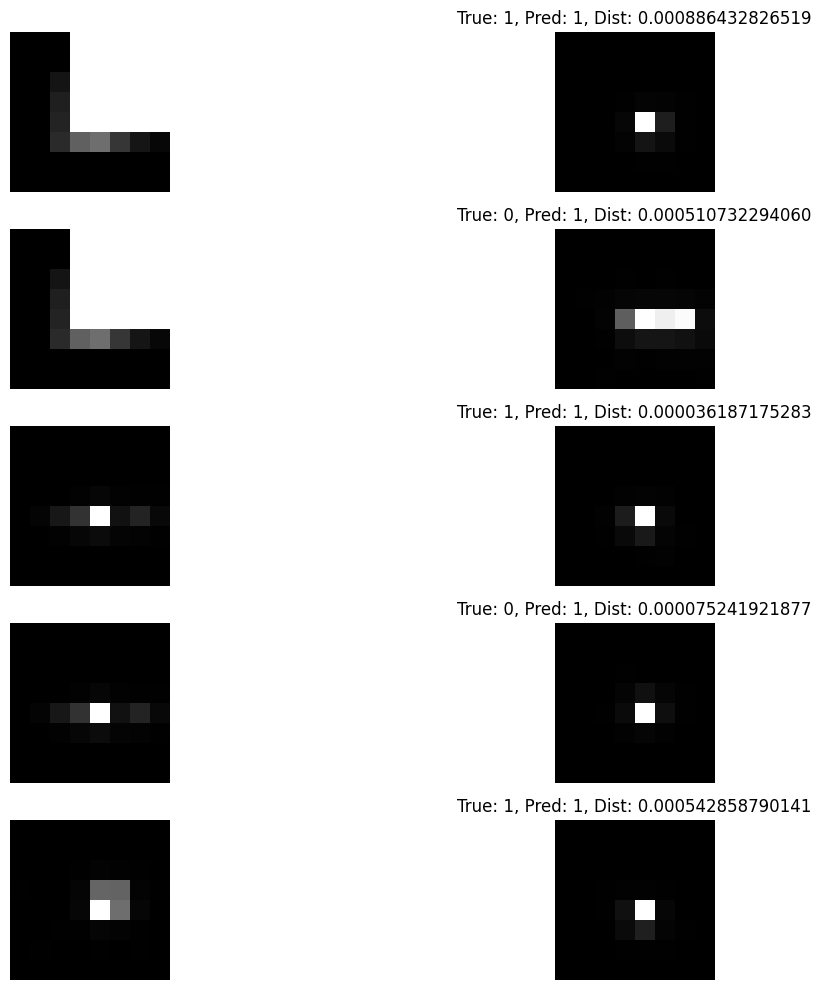

In [58]:
# Plot sample pairs with predictions
plot_samples_with_predictions(pairs_test, labels_test, y_pred, distance, size=8, num_samples=5)

In [64]:
wandb.finish()